#  Team6Project1Py

## Project Description:
### This project attempts to analyze the impact that the COVID-19 pandemic has had on the United States relative to overall testing, confirmed cases, hospitalizations and death rates. The analysis is refined to illustrate outcomes for the following comparisons:
####     1) Impact on Minnesota vs. Michigan (Chosen because of population similarities). 
####     2) Impact on Minnesota vs. Colorado  (Chosen because of population similarities). 
####     3) Impact on Minnesota vs. the National Average
####     4) Impact Minneapolis/St. Paul MN. vs. Detroit MI. (Cities of comparable population size and density).

## Solution Approach:
###  1) Identify applicable Data Sources for all required analysis. These were as follows:
####         -  API calls to the Census.gov site to obtain state and county populations as well as geographic areas in the U.S.
####         -  API calls to the covidtracking.com site to obtain historical and summary level data for the following: Testing Outcomes,   Hospitalizations and Death.
####         -  A .csv input file obtained from a Johns Hopkins University portal that is dedicated to the COVID-19 pandemic analysis. This file provided population, confimed cases, active cases and death statistics for all counties in the U.S. 

###  2) Loading and standardizing all inputs identified above into pandas dataframes and producing working .csv files that enabled all data visualizations.




In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.optimize as op
from scipy.optimize import curve_fit as cf
import pandas as pd
import numpy as np
import requests
import gmaps
import os
import json
from census import Census

# Census API Key
from config import (api_key, gkey)
c = Census(api_key, year=2018)

# gmaps API Key 
gmaps.configure(api_key=gkey)

# define current date string to append to the names of output files...
import datetime  
def _getToday(): return datetime.date.today().strftime("%Y%m%d")   

### Census.gov API calls to get state and county populations in the U.S.

In [2]:
State_Abbrev_df = pd.read_excel("Excel_Files/StateAbbreviation.xlsx")
State_Abbrev_df

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,Florida,FL
9,Georgia,GA


In [3]:
# Get state Populations...
census_state_data = c.acs5.get(("NAME", "B01003_001E"), {'for': 'state:*'})
# Convert to DataFrame
census_state_df = pd.DataFrame(census_state_data)

# Column Reordering
census_state_df = census_state_df.rename(columns={"NAME": "State", "B01003_001E": "Population"})
del census_state_df['state']

census_state_df = pd.merge(census_state_df, State_Abbrev_df, on='State', how='inner') 
Census_State_Population = "%s_%s.%s" % ("Output_Data/Census_State_Population", _getToday() ,"csv")
census_state_df.to_csv(Census_State_Population, encoding='utf-8', index=False)

census_state_df


# Get County Populations...
census_county_data = c.acs5.get(("NAME", "B01003_001E"), {'for': 'county:*'})
# Convert to DataFrame
census_county_df = pd.DataFrame(census_county_data)
# Column Reordering
census_county_df = census_county_df.rename(columns={"NAME": "Name",  "county": "County","B01003_001E": "Population"})                                     
census_temp_df = census_county_df[['County','State']] = census_county_df.Name.str.split(", ",expand=True,)
census_temp_df = census_county_df[['County','Literal']] = census_county_df.County.str.split(" County",expand=True,)
del census_county_df['Name'] 
del census_county_df['state']
del census_county_df['Literal']

census_county_df = pd.merge(census_county_df, State_Abbrev_df, on='State', how='inner') 

Census_County_Population = "%s_%s.%s" % ("Output_Data/Census_County_Population", _getToday() ,"csv")
census_county_df.to_csv(Census_County_Population, encoding='utf-8', index=False)

census_county_df

,Population,County,State,Abbreviation
0,47086.0,Washington,Mississippi,MS
1,12028.0,Perry,Mississippi,MS
2,8321.0,Choctaw,Mississippi,MS
3,23480.0,Itawamba,Mississippi,MS
4,10129.0,Carroll,Mississippi,MS
...,...,...,...,...
3137,19994.0,Carroll,Indiana,IN
3138,36378.0,Huntington,Indiana,IN
3139,24217.0,White,Indiana,IN
3140,20993.0,Jay,Indiana,IN


### COVID Tracking API Calls to get historical and summary data at the State Level
 

In [4]:

#get state historical data - MN
covid_state_url = "https://covidtracking.com/api/v1/states/mn/daily.json?"
covidAPI_response_df = pd.DataFrame(requests.get(covid_state_url).json())
covid_state_df = pd.DataFrame (
        {'Date' : covidAPI_response_df['date'],
         'State' : covidAPI_response_df['state'],
         'Positive' : covidAPI_response_df['positive'],
         'Negative' : covidAPI_response_df['negative'],
         'Recovered' : covidAPI_response_df['recovered'],
         'Date_Checked' : covidAPI_response_df['dateChecked'],
         'Death' : covidAPI_response_df['death'],
         'Hospitalized' : covidAPI_response_df['hospitalized'],
         'Total_Test_Results' : covidAPI_response_df['totalTestResults'],
         'Death_Increase' : covidAPI_response_df['deathIncrease'],
         'Hospitalized_Increase' : covidAPI_response_df['hospitalizedIncrease'],
         'Negative_Increase' : covidAPI_response_df['negativeIncrease'],
         'Positive_Increase' : covidAPI_response_df['positiveIncrease'],
         'Total_Test_Results_Increase' : covidAPI_response_df['totalTestResultsIncrease']})

COV_Tracking_MN_History = "%s_%s.%s" % ("Output_Data/COV_Tracking_MN_History_data", _getToday() ,"csv")
covid_state_df.to_csv(COV_Tracking_MN_History, encoding='utf-8', index=False)
covid_state_df 

#get state historical data - MI
covid_stateMI_url = "https://covidtracking.com/api/v1/states/mi/daily.json?"
covidAPI_responseMI_df = pd.DataFrame(requests.get(covid_stateMI_url).json())
covid_stateMI_df = pd.DataFrame (
        {'Date' : covidAPI_responseMI_df['date'],
         'State' : covidAPI_responseMI_df['state'],
         'Positive' : covidAPI_responseMI_df['positive'],
         'Negative' : covidAPI_responseMI_df['deathIncrease'],
         'Recovered' : covidAPI_responseMI_df['recovered'],
         'Date_Checked' : covidAPI_responseMI_df['dateChecked'],
         'Death' : covidAPI_responseMI_df['death'],
         'Hospitalized' : covidAPI_responseMI_df['hospitalized'],
         'Total_Test_Results' : covidAPI_responseMI_df['totalTestResults'],
         'Death_Increase' : covidAPI_responseMI_df['deathIncrease'],
         'Hospitalized_Increase' : covidAPI_responseMI_df['hospitalizedIncrease'],
         'Negative_Increase' : covidAPI_responseMI_df['negativeIncrease'],
         'Positive_Increase' : covidAPI_responseMI_df['positiveIncrease'],
         'Total_Test_Results_Increase' : covidAPI_responseMI_df['totalTestResultsIncrease']})

COV_Tracking_MI_History = "%s_%s.%s" % ("Output_Data/COV_Tracking_MI_History_data", _getToday() ,"csv")
covid_stateMI_df.to_csv(COV_Tracking_MI_History, encoding='utf-8', index=False)
covid_stateMI_df 

#get state historical data - CO
covid_stateCO_url = "https://covidtracking.com/api/v1/states/co/daily.json?"
covidAPI_responseCO_df = pd.DataFrame(requests.get(covid_stateCO_url).json())
covid_stateCO_df = pd.DataFrame (
        {'Date' : covidAPI_responseCO_df['date'],
         'State' : covidAPI_responseCO_df['state'],
         'Positive' : covidAPI_responseCO_df['positive'],
         'Negative' : covidAPI_responseCO_df['negative'],
         'Recovered' : covidAPI_responseCO_df['recovered'],
         'Date_Checked' : covidAPI_responseCO_df['dateChecked'],
         'Death' : covidAPI_responseCO_df['death'],
         'Hospitalized' : covidAPI_responseCO_df['hospitalized'],
         'Total_Test_Results' : covidAPI_responseCO_df['totalTestResults'],
         'Death_Increase' : covidAPI_responseCO_df['deathIncrease'],
         'Hospitalized_Increase' : covidAPI_responseCO_df['hospitalizedIncrease'],
         'Negative_Increase' : covidAPI_responseCO_df['negativeIncrease'],
         'Positive_Increase' : covidAPI_responseCO_df['positiveIncrease'],
         'Total_Test_Results_Increase' : covidAPI_responseCO_df['totalTestResultsIncrease']})

COV_Tracking_CO_History = "%s_%s.%s" % ("Output_Data/COV_Tracking_CO_History_data", _getToday() ,"csv")
covid_stateCO_df.to_csv(COV_Tracking_CO_History, encoding='utf-8', index=False)
covid_stateCO_df 

#get state summary data
covid_currstate_url = "https://covidtracking.com/api/v1/states/mn/current.json?"
covidAPI_currresponse_df = pd.DataFrame(requests.get(covid_currstate_url).json(), index=[0])
covid_currstate_df = pd.DataFrame (        
         {'State' : covidAPI_currresponse_df['state'],
         'Positive' : covidAPI_currresponse_df['positive'],
         'Negative' : covidAPI_currresponse_df['negative'],
         'Recovered' : covidAPI_currresponse_df['recovered'],
         'Date_Checked' : covidAPI_currresponse_df['dateChecked'],
         'Death' : covidAPI_currresponse_df['death'],
         'Hospitalized' : covidAPI_currresponse_df['hospitalized'],
         'Total_Test_Results' : covidAPI_currresponse_df['totalTestResults']})

COV_Tracking_MN_Summary = "%s_%s.%s" % ("Output_Data/COV_Tracking_MN_Summary_data", _getToday() ,"csv")
covid_currstate_df.to_csv(COV_Tracking_MN_Summary, encoding='utf-8', index=False)
covid_currstate_df 

,State,Positive,Negative,Recovered,Date_Checked,Death,Hospitalized,Total_Test_Results
0,MN,3185,50602,1594,2020-04-24T21:03:00Z,221,756,53787


### COVID Tracking API Calls to get summary and historical data  at the National Level

In [5]:
#get national history data
covid_national_url = "https://covidtracking.com/api/us/daily.json?"
covidAPI_natresp_df = pd.DataFrame(requests.get(covid_national_url).json())
covid_national_df = pd.DataFrame (
        {'Date' : covidAPI_natresp_df['date'],
         'States' : covidAPI_natresp_df['states'],
         'Positive' : covidAPI_natresp_df['positive'],
         'Negative' : covidAPI_natresp_df['negative'],
         'Recovered' : covidAPI_natresp_df['recovered'],
         'Date_Checked' : covidAPI_natresp_df['dateChecked'],
         'Death' : covidAPI_natresp_df['death'],
         'Hospitalized' : covidAPI_natresp_df['hospitalized'],
         'Total_Test_Results' : covidAPI_natresp_df['totalTestResults'],
         'Death_Increase' : covidAPI_natresp_df['deathIncrease'],
         'Hospitalized_Increase' : covidAPI_natresp_df['hospitalizedIncrease'],
         'Negative_Increase' : covidAPI_natresp_df['negativeIncrease'],
         'Positive_Increase' : covidAPI_natresp_df['positiveIncrease'],
         'Total_Test_Results_Increase' : covidAPI_natresp_df['totalTestResultsIncrease']})

COV_Tracking_US_History = "%s_%s.%s" % ("Output_Data/COV_Tracking_US_History_data", _getToday() ,"csv")
covid_national_df.to_csv(COV_Tracking_US_History, encoding='utf-8', index=False)
covid_national_df 

#get national summary data
covid_natsum_url = "https://covidtracking.com/api/v1/states/current.json?"
covidAPI_natsum_df = pd.DataFrame(requests.get(covid_natsum_url).json())
covid_natsum_df = pd.DataFrame (        
         {'State' : covidAPI_natsum_df['state'],
         'Positive' : covidAPI_natsum_df['positive'],
         'Negative' : covidAPI_natsum_df['negative'],
         'Recovered' : covidAPI_natsum_df['recovered'],
         'Date_Checked' : covidAPI_natsum_df['dateChecked'],
         'Death' : covidAPI_natsum_df['death'],
         'Hospitalized' : covidAPI_natsum_df['hospitalized'],
         'Total_Test_Results' : covidAPI_natsum_df['totalTestResults']})
         
COV_Tracking_US_Summary = "%s_%s.%s" % ("Output_Data/COV_Tracking_US_Summary_data", _getToday() ,"csv")
covid_natsum_df.to_csv(COV_Tracking_US_Summary, encoding='utf-8', index=False)
covid_natsum_df 

,State,Positive,Negative,Recovered,Date_Checked,Death,Hospitalized,Total_Test_Results
0,AK,339,11942,208.0,2020-04-24T20:02:00Z,9,NaN,12281
1,AL,6026,46863,NaN,2020-04-25T02:17:00Z,209,769.0,52889
2,AR,2741,32837,929.0,2020-04-24T19:42:00Z,45,291.0,35578
3,AZ,6045,54669,1313.0,2020-04-24T19:39:00Z,266,984.0,60714
4,CA,39254,454919,NaN,2020-04-25T02:06:00Z,1562,NaN,494173
5,CO,12256,44533,NaN,2020-04-25T02:32:00Z,674,2366.0,56789
6,CT,23921,50117,NaN,2020-04-24T21:03:00Z,1764,NaN,74038
7,DC,3528,13005,651.0,2020-04-24T20:11:00Z,153,NaN,16533
8,DE,3442,13937,703.0,2020-04-25T03:01:00Z,100,NaN,17379
9,FL,30533,288505,NaN,2020-04-25T02:54:00Z,1066,5009.0,319038


### John Hopkins University stats for ALL U.S. Counties

In [6]:
# Load the JHU data
JHU_data_df = pd.read_csv("Excel_Files/JHU-04-23-2020.csv")
JHU_data_df = JHU_data_df.dropna()
JHU_data_df = JHU_data_df.rename(columns={"Admin2": "County"})
JHU_data_df = pd.merge(JHU_data_df, State_Abbrev_df, left_on=['Province_State'], right_on=['State'], how='left')
JHU_data_df = pd.merge(JHU_data_df, census_county_df, 
                       left_on=['State', 'County'], right_on=['State', 'County'], how='inner')
del JHU_data_df['Abbreviation_y'] 
del JHU_data_df['State']
JHU_data_df = JHU_data_df.rename(columns={"Abbreviation_x": "Abbreviation", "Province_State": "State"})

JHU_data = "%s_%s.%s" % ("Output_Data/JHU_data", _getToday() ,"csv")
JHU_data_df.to_csv(JHU_data, encoding='utf-8', index=False)

JHU_data_df

,FIPS,County,State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Abbreviation,Population
0,45001.0,Abbeville,South Carolina,US,4/24/2020 3:30,34.223334,-82.461707,23,0,0,23,"Abbeville, South Carolina, US",SC,24657.0
1,51001.0,Accomack,Virginia,US,4/24/2020 3:30,37.767072,-75.632346,76,2,0,74,"Accomack, Virginia, US",VA,32742.0
2,16001.0,Ada,Idaho,US,4/24/2020 3:30,43.452658,-116.241552,635,14,0,621,"Ada, Idaho, US",ID,446052.0
3,19001.0,Adair,Iowa,US,4/24/2020 3:30,41.330756,-94.471059,1,0,0,1,"Adair, Iowa, US",IA,7124.0
4,21001.0,Adair,Kentucky,US,4/24/2020 3:30,37.104598,-85.281297,63,5,0,58,"Adair, Kentucky, US",KY,19241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660,6115.0,Yuba,California,US,4/24/2020 3:30,39.262559,-121.353564,16,1,0,15,"Yuba, California, US",CA,75493.0
2661,4027.0,Yuma,Arizona,US,4/24/2020 3:30,32.768957,-113.906667,42,1,0,41,"Yuma, Arizona, US",AZ,207829.0
2662,8125.0,Yuma,Colorado,US,4/24/2020 3:30,40.003468,-102.425867,5,0,0,5,"Yuma, Colorado, US",CO,10069.0
2663,48505.0,Zapata,Texas,US,4/24/2020 3:30,27.001564,-99.169872,7,0,0,7,"Zapata, Texas, US",TX,14369.0


In [7]:
JHU_County_Compare_df = JHU_data_df.loc[((JHU_data_df['County'] == 'Wayne') & (JHU_data_df['State'] == 'Michigan')) |
                                        ((JHU_data_df['County'] == 'Hennepin') & (JHU_data_df['State'] == 'Minnesota')) |
                                        ((JHU_data_df['County'] == 'Ramsey') & (JHU_data_df['State'] == 'Minnesota'))]

JHU_County_Compare_df = JHU_County_Compare_df.groupby(['State'], as_index=False).sum()
JHU_County_Compare_df = JHU_County_Compare_df.rename(columns={"State": "County"})
JHU_County_Compare_df['County'].replace("Michigan", "Wayne (MI)", inplace=True)
JHU_County_Compare_df['County'].replace("Minnesota", "Hennepin-Ramsey (MN)", inplace=True)

JHU_compare = "%s_%s.%s" % ("Output_Data/JHU_compare", _getToday() ,"csv")
JHU_County_Compare_df.to_csv(JHU_compare, encoding='utf-8', index=False)
JHU_County_Compare_df

,County,FIPS,Lat,Long_,Confirmed,Deaths,Recovered,Active,Population
0,Wayne (MI),26163.0,42.280984,-83.281255,14994,1396,0,13598,1761382.0
1,Hennepin-Ramsey (MN),54176.0,90.023868,-186.575672,1367,137,0,1230,1776971.0


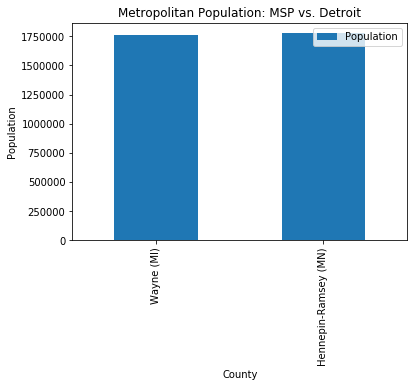

<Figure size 432x288 with 0 Axes>

In [8]:
# Bar chart of the data...
JHU_County_Compare_df.plot(kind = 'bar', x = 'County', y = 'Population')
#JHU_County_Compare_df.plot(kind="bar", figsize=(10,3))

# Set a title for the chart
plt.title("Metropolitan Population: MSP vs. Detroit")
plt.xlabel("County")
plt.ylabel("Population")

plt.savefig("Images/PopulationMSPvDetroit.png")
plt.show()
plt.tight_layout()


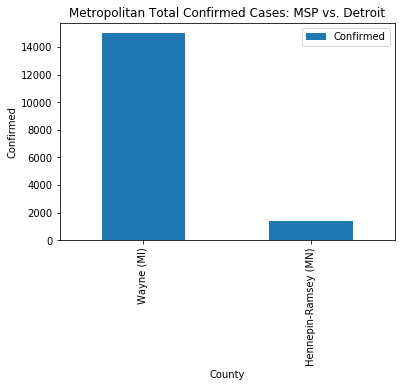

<Figure size 432x288 with 0 Axes>

In [9]:
# Bar chart of the data...
JHU_County_Compare_df.plot(kind = 'bar', x = 'County', y = 'Confirmed')
#JHU_County_Compare_df.plot(kind="bar", figsize=(10,3))

# Set a title for the chart
plt.title("Metropolitan Total Confirmed Cases: MSP vs. Detroit")
plt.xlabel("County")
plt.ylabel("Confirmed")

plt.savefig("Images/Total CasesMSPvDetroit.png")
plt.show()
plt.tight_layout()


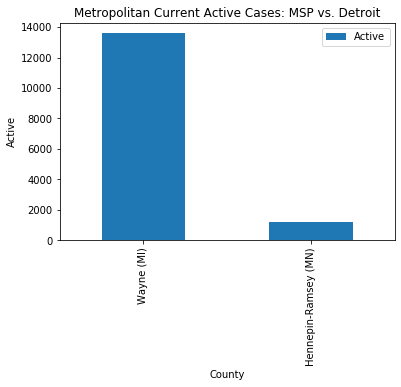

<Figure size 432x288 with 0 Axes>

In [10]:
# Bar chart of the data...
JHU_County_Compare_df.plot(kind = 'bar', x = 'County', y = 'Active')
#JHU_County_Compare_df.plot(kind="bar", figsize=(10,3))

# Set a title for the chart
plt.title("Metropolitan Current Active Cases: MSP vs. Detroit")
plt.xlabel("County")
plt.ylabel("Active")

plt.savefig("Images/CurrentActiveMSPvDetroit.png")
plt.show()
plt.tight_layout()

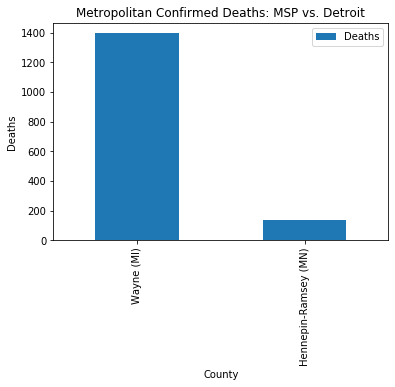

<Figure size 432x288 with 0 Axes>

In [11]:
# Bar chart of the data...
JHU_County_Compare_df.plot(kind = 'bar', x = 'County', y = 'Deaths')
#JHU_County_Compare_df.plot(kind="bar", figsize=(10,3))

# Set a title for the chart
plt.title("Metropolitan Confirmed Deaths: MSP vs. Detroit")
plt.xlabel("County")
plt.ylabel("Deaths")

plt.savefig("Images/DeathsMSPvDetroit.png")
plt.show()
plt.tight_layout()


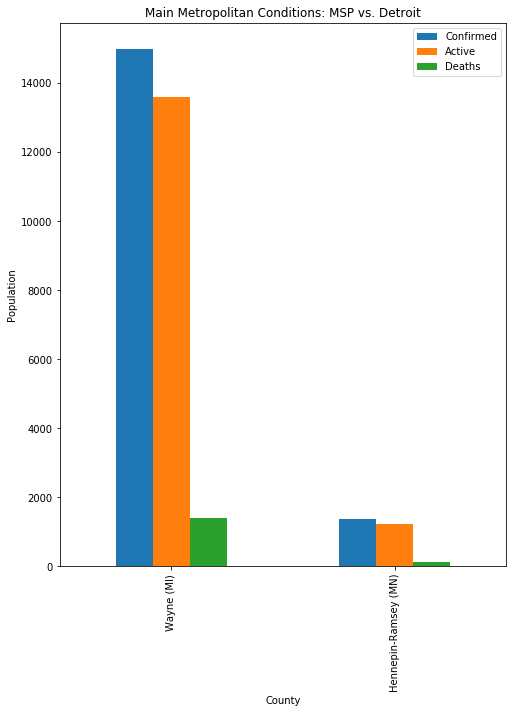

<Figure size 432x288 with 0 Axes>

In [12]:
# Bar chart of the data...
#plot_data = JHU_County_Compare_df[["County","Population", "Confirmed", "Deaths", "Active"]]
plot_data = JHU_County_Compare_df[["County", "Confirmed", "Active", "Deaths"]]

# Set the index to be "County"  
plot_data = plot_data.set_index("County")

#JHU_County_Compare_df.plot(kind = 'bar', x = 'County', y = 'Population')
plot_data.plot(kind="bar", figsize=(8,10))

# Set a title for the chart
plt.title("Main Metropolitan Conditions: MSP vs. Detroit")
plt.xlabel("County")
plt.ylabel("Population")

plt.savefig("Images/ConditionsMSPvDetroit.png")
plt.show()
plt.tight_layout()
